## Model evaluation

In [1]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Statistics
using Unicode
using Random

In [2]:
using Revise
using TokenizersLite
using TransformersLite

In [3]:
include("../../common/reporting.jl")
include("../../common/vocab.jl")
include("../../common/training.jl")
include("../../common/SentenceClassifier.jl")

v_weighted_average (generic function with 1 method)

## Load data

raw

In [5]:
fingerprint = "724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609"
data_dir = joinpath("..\\..\\datasets\\amazon_reviews_multi\\en\\1.0.0\\", fingerprint)
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [6]:
filepath = joinpath(data_dir, file_train)
df = DataFrame(Arrow.Table(filepath))
println("rows: ", nrow(df))

filepath = joinpath(data_dir, file_test)
df_test = DataFrame(Arrow.Table(filepath));
println("rows: ", nrow(df_test))

rows: 200000
rows: 5000


filtered

In [7]:
documents = df[:, :review_body]
labels = df[:, :stars]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [8]:
documents_test = df_test[:, :review_body]
labels_test = df_test[:, :stars];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [25]:
directory = "outputs/20240212_n1_sentence"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 4 entries:
  :tokenizer         => BytePairEncoder{String}(length(rules)=8000, length(cach…
  :indexer           => IndexTokenizer{String}(length(vocabulary)=7455, unksym=…
  :sentence_splitter => RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z…
  :model             => SentenceClassifer(base_model=TransformerClassifier{Embe…

In [10]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
sentence_splitter = saved_objects[:sentence_splitter ]
@show sentence_splitter 
model = saved_objects[:model]
display(model)
display(model.base_model)
display(model.aggregate)

tokenizer = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])
sentence_splitter = RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z", "C", "P", "Jul", "Eg", "Dec", "Sen", "Rev", "Mar", "BComm", "co", "Mon", "Sep", "Y", "U", "Jan", "Fig", "Prof", "al", "K", "BA", "V", "BSc", "Ph.d", "Phd", "H", "Feb", "Rep", "Mr", "S", "MA", "Jr", "PhD", "F", "W", "T", "Aug", "Dept", "L", "O", "B", "fig", "M", "Capt", "Sun", "Gen", "prof", "X", "Corp", "Gov", "Tues", "corp", "Ie", "D", "BCom", "BEng

SentenceClassifer(base_model=TransformersLite.TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{Matrix{Float32}}, Dropout{Float64, Colon, TaskLocalRNG}, Vector{TransformerBlock{TransformersLite.MultiHeadAttention{Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Bool}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Nothing}, LayerNorm{typeof(identity), Flux.Scale{typeof(identity), Vector{Float32}, Vector{Float32}}, Float32, 1}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, LayerNorm{typeof(identity), Flux.Scale{typeof(identity), Vector{Float32}, Vector{Float32}}, Float32, 1}, Dropout{Float64, Colon, TaskLocalRNG}}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, FlattenLayer, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}(Embed((8, 7455)), PositionEncoding(8), Dropout(0.1), Transformer

TransformerClassifier(
  Embed((8, 7455)),                     # 59_640 parameters
  PositionEncoding(8),
  Dropout(0.1),
  TransformerBlock(
    MultiHeadAttention(num_heads=4, head_size=2, 8=>8)(
      denseQ = Dense(8 => 8; bias=false),  # 64 parameters
      denseK = Dense(8 => 8; bias=false),  # 64 parameters
      denseV = Dense(8 => 8; bias=false),  # 64 parameters
      denseO = Dense(8 => 8),           # 72 parameters
      mask = nothing,
    ),
    Dropout(0.1),
    LayerNorm(8),                       # 16 parameters
    Dense(8 => 32, relu),               # 288 parameters
    Dense(32 => 8),                     # 264 parameters
    Dropout(0.1),
    LayerNorm(8),                       # 16 parameters
  ),
  Dense(8 => 1),                        # 9 parameters
  FlattenLayer(),
  Dense(30 => 1),                       # 31 parameters
)        # Total: 18 trainable arrays, 60_528 parameters,
          # plus 1 non-trainable, 8_000 parameters, summarysize 269.258 KiB.

parabolic_weighted_average (generic function with 1 method)

In [12]:
max_length = size(model.base_model.head.weight, 2)

30

## Tokenizers

In [13]:
function pad!(v::Vector{String}, symbol::String, max_length::Int)
    if length(v) < max_length
        padding = fill(symbol, max_length - length(v))
        append!(v, padding)
    end
end

pad! (generic function with 1 method)

In [14]:
@time documents_split = map(sentence_splitter, documents)
@time documents_test_split = map(sentence_splitter, documents_test);

  8.000988 seconds (57.00 M allocations: 3.774 GiB, 11.26% gc time, 2.39% compilation time)
  0.194376 seconds (1.41 M allocations: 94.447 MiB, 9.18% gc time)


In [15]:
y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3
y_train = y_train[idxs];

tokens = Vector{Vector{String}}[]
@time for sentences in documents_split[idxs]
    tokens_doc = map(s->preprocess(s, tokenizer, max_length=max_length), sentences)
    pad!(tokens_doc[1], tokenizer.unksym, max_length) # hack to ensure all indices have common length
    push!(tokens, tokens_doc)
end
@time indices = map(t->indexer(t), tokens) 

X_train = indices
train_data, val_data = split_validation(MersenneTwister(2718), X_train, y_train)
println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 41.893064 seconds (635.16 M allocations: 16.602 GiB, 11.09% gc time, 1.31% compilation time)
  1.100666 seconds (449.96 k allocations: 142.928 MiB, 2.21% gc time, 12.90% compilation time)
train samples:      (144000,) (144000,)
validation samples: (16000,) (16000,)


In [16]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3

tokens = Vector{Vector{String}}[]
@time for sentences in documents_test_split
    tokens_doc = map(s->preprocess(s, tokenizer, max_length=max_length), sentences)
    pad!(tokens_doc[1], tokenizer.unksym, max_length) # hack to ensure all indices have common length
    push!(tokens, tokens_doc)
end
@time indices_test = map(t->indexer(t), tokens) 

X_test, y_test = indices_test[idxs], y_test[idxs]
documents_test_sub = documents_test[idxs]

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.712147 seconds (8.06 M allocations: 235.681 MiB, 5.59% gc time, 7.46% compilation time)
  0.075856 seconds (40.39 k allocations: 6.147 MiB, 65.75% compilation time)
test indices: (5000,)
test samples: (4000,) (4000,)


In [17]:
train_data_loader = DataLoader(train_data; batchsize=32, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=32, shuffle=false);

## Evaluate

In [18]:
loss(ŷ::AbstractVector, y::AbstractVector) = Flux.binarycrossentropy(ŷ, y);
accuracy(ŷ::AbstractVector, y::AbstractVector) = mean((ŷ .> 0.5) .== y);

In [20]:
batched_metrics(model, train_data_loader, accuracy, loss)

batch metrics... 100%|███████████████████████████████████| Time: 0:00:37


(accuracy = 0.9035208f0, loss = 0.25712088f0)

In [21]:
batched_metrics(model, val_data_loader, accuracy, loss)

batch metrics... 100%|███████████████████████████████████| Time: 0:00:04


(accuracy = 0.8894375f0, loss = 0.2847681f0)

In [26]:
history = open(joinpath(directory, "history.json"), "r") do f
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 5 entries:
  "train_loss"      => Any[0.470877, 0.361859, 0.320746, 0.3018, 0.287606, 0.28…
  "train_accuracy"  => Any[0.781146, 0.849965, 0.872132, 0.881965, 0.889583, 0.…
  "mean_batch_loss" => Any[0.64915, 0.43497, 0.365664, 0.335236, 0.316798, 0.30…
  "val_accuracy"    => Any[0.78725, 0.849187, 0.86775, 0.874, 0.881938, 0.88125…
  "val_loss"        => Any[0.46874, 0.360907, 0.326713, 0.311489, 0.299723, 0.2…

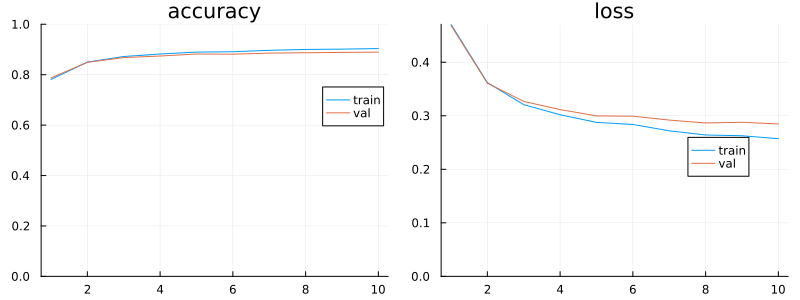

In [27]:
epochs = 1:length(history["train_accuracy"])
p1 = plot(epochs, history["train_accuracy"], label="train")
plot!(p1, epochs, history["val_accuracy"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [28]:
probs = model(X_test)
accuracy(probs, y_test)

0.88525

In [29]:
y_pred = Int.(probs .> 0.5);

In [30]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1785   215
  244  1756

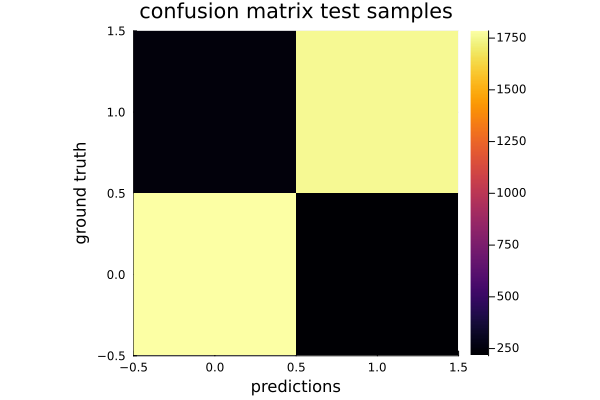

In [31]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
savefig(p, joinpath(directory, "confusion_matrix_classification.png"))
p

In [32]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.88    0.89      0.89     2000
           1       0.89    0.88      0.88     2000

weighted avg       0.89    0.89      0.89     4000

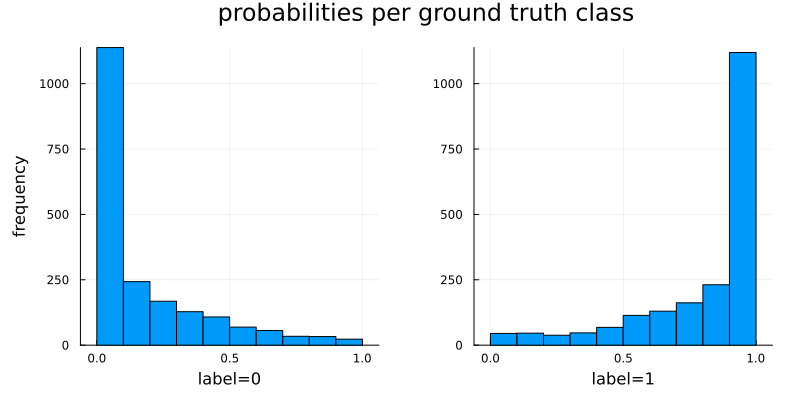

In [33]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_ground_truth.png"))
p

### Examples

In [34]:
pos_max = argmax(probs)
pos_min = argmin(probs)


println(" idx  y  ŷ    prob  ")
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_max, y_test[pos_max], y_pred[pos_max], probs[pos_max], documents_test_sub[pos_max]
)
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_min, y_test[pos_min], y_pred[pos_min], probs[pos_min], documents_test_sub[pos_min]
)

 idx  y  ŷ    prob  
3036  1  1  0.9999  Works very well, easy install
 150  0  0  0.0007  This product arrived late and no return policy.


In [35]:
nshow = 3

for label in [0, 1]
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 1))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            @printf("%4d  %d  %d  %.4f\n",
                idx, y_test[idx], y_pred[idx], probs[idx], 
            )
            sentences = documents_test_split[labels_test.!==3][idx]
            y = predict_probs(model, X_test[idx])
            for (p, s) in zip(y, sentences)
                @printf("\t    %.4f %s\n", p, s)
            end
        end
    end
    println("")
end

correct: 1785 / 2000
 idx  y  ŷ    prob  
1795  0  0  0.2833
	    0.2833 The water socks protected my feet but the were weird feeling and they seem as if worn too much my toes may push through the fabric.
 212  0  0  0.2001
	    0.1017 I ordered this Instant Pot Pressure Cookbook when it was on sale through Amazon.
	    0.0060 There is poor editing throughout this recipe book.
	    0.1118 Many recipes have missing steps and ingredients.
	    0.0710 There is no index, only a table of contents that is difficult to use.
	    0.1317 Even the table of contents is not alphabetized so you have to read down the entire list to find a recipe.
	    0.5302 The author assumes you already know how to use the Instant Pot.
	    0.5215 There are no reminders regarding sealing the Instant Pot lid or any other safety instructions.
	    0.8957 These instructions would have been helpful to those of us who are new to the Instant Pot.
 357  0  0  0.1333
	    0.0883 I bought this as a tracker to use while I s

## Influence of sentence count

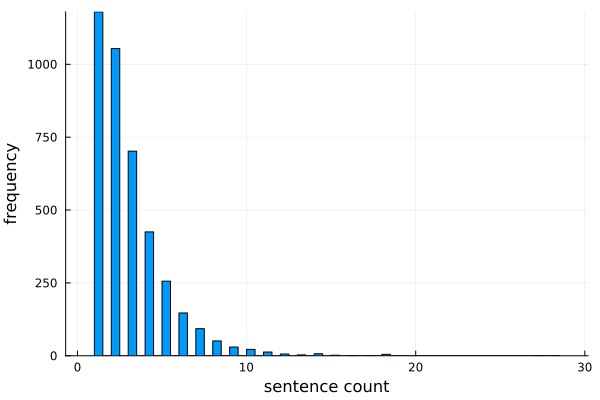

In [36]:
sentence_counts = length.(documents_test_split[labels_test .!= 3])

p = histogram(sentence_counts, xlabel="sentence count", ylabel="frequency", label="")
savefig(p, joinpath(directory, "sentence_counts.png"))
p

In [37]:
accuracies = Float64[]
sentence_count_frequencies = Int[]
for sentence_count in 1:maximum(sentence_counts)
    idxs = sentence_counts .== sentence_count;
    acc = count(idxs) > 0 ? accuracy(probs[idxs], y_test[idxs]) : NaN
    push!(sentence_count_frequencies, count(idxs))
    push!(accuracies, acc)
end

In [38]:
cum_accuaracies = Float64[]
count_total = 0
acc = 0.0
for i in 1:maximum(sentence_counts)
    count_i = count(sentence_counts .== i)
    acc_i = isnan(accuracies[i]) ? 0 : accuracies[i]
    acc = (count_i * acc_i + count_total * acc)/(count_i + count_total)
    count_total += count_i
    push!(cum_accuaracies, acc)
end

In [39]:
cum_sentence_counts = cumsum(sentence_count_frequencies  .* (1:length(sentence_count_frequencies)));
cum_sentence_counts /= cum_sentence_counts[end];

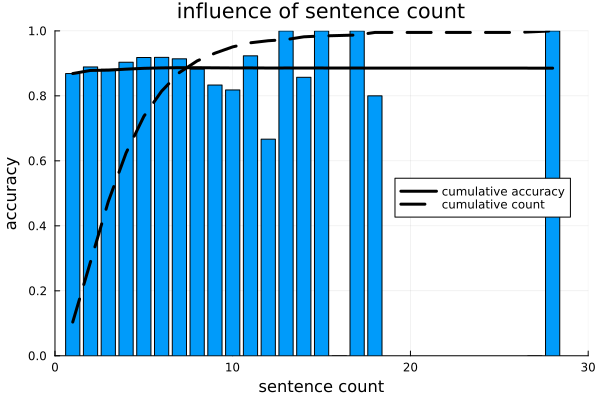

In [40]:
bar(1:maximum(sentence_counts), accuracies, label="",
    xlabel="sentence count",
    ylabel="accuracy",
    title="influence of sentence count",
    ylims=(0, 1),
    xlims=(0, maximum(sentence_counts) + 2),
    )
p = plot!(
    1:maximum(sentence_counts), cum_accuaracies, label="cumulative accuracy", 
    legend_position=:right, color=:black, linewidth=3
)
p = plot!(
    1:maximum(sentence_counts), cum_sentence_counts, label="cumulative count",
    linewidth=3, legend_position=:right, color=:black, linestyle=:dash
)
savefig(p, joinpath(directory, "accuracy_sentence_count.png"))
p

Zoom in on graph

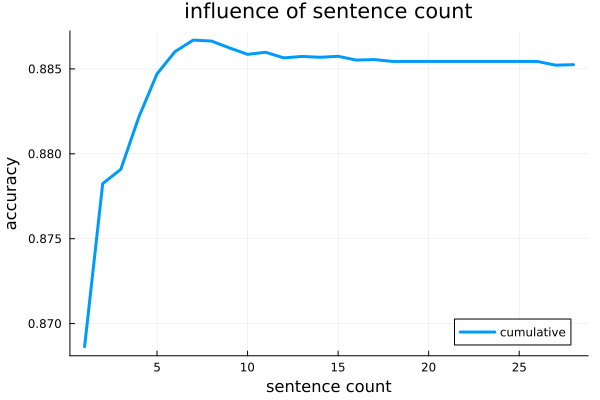

In [41]:
p = plot(1:maximum(sentence_counts), cum_accuaracies, linewidth=3, label="cumulative",
    xlabel="sentence count",
    ylabel="accuracy",
    title="influence of sentence count",
    )
savefig(p, joinpath(directory, "accuracy_sentence_count_cummulative.png"))
p

### Test data including star=3

In [42]:
probs_all = model(indices_test);
y_pred_all = Int.(probs_all .> 0.5);

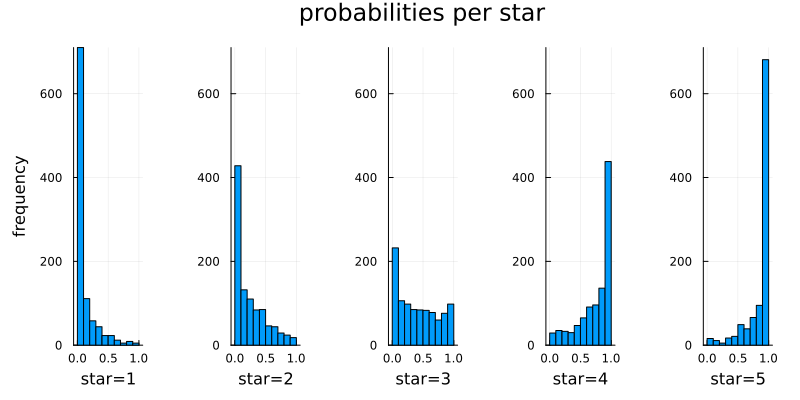

In [43]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per star",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_star.png"))
p

In [44]:
nshow = 3

star = 3
println("star = $star")
idxs = labels_test .== star
idxs_label = (1:length(labels_test))[vec(idxs)]
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_label, nshow, replace=false)
    @printf("%4d  %d  %d  %.4f\n",
            idx, y_test[idx], y_pred[idx], probs[idx], 
        )
    sentences = documents_test_split[idx]
    y = predict_probs(model, X_test[idx])
    for (p, s) in zip(y, sentences)
        @printf("\t    %.4f %s\n", p, s)
    end
end

star = 3
 idx  y  ŷ    prob  
2898  1  1  0.9715
	    0.9852 Much smaller than anticipated.
	    0.9997 More like a notepad size than a book.
2749  1  1  0.9653
	    0.9964 This smells amazing!
	    0.9222 I love the scent....however as a deodorant?
2550  1  1  0.9597
	    0.9597 Really nice looking but very heavy and sweats easily.


## Single samples

In [45]:
idx = 4700  

text = documents_test[idx]

println(labels_test[idx])
println(text)
println("")

sentences = sentence_splitter(text)
tokens = [preprocess(s, tokenizer, max_length=max_length) for s in sentences]
for t in tokens
    println(join(t, "|"))
end
pad!(tokens[1], tokenizer.unksym, max_length)
x = indexer(tokens);

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.

⋅this|⋅makes|⋅almost|⋅the|⋅whole|⋅series
⋅rom|##an|⋅nights|⋅will|⋅be|⋅the|⋅last|⋅one
⋅loved|⋅them|⋅all
⋅al|##ask|##an|⋅nights|⋅was|⋅awesome
⋅met|⋅my|⋅expectations|⋅hot|⋅seal|⋅hero|⋅beautiful|⋅fe|##ist|##y|⋅woman
⋅filled|⋅with|⋅intrig|##ue|⋅stea|##my|⋅romance|⋅nail|⋅bit|##ing|⋅ending
⋅have|⋅read|⋅two|⋅other|⋅books|⋅of|⋅your|##s
⋅am|⋅looking|⋅forward|⋅to|⋅more


In [46]:
y = predict_probs(model, x)
@printf "mean: %.4f ; weighted mean: %.4f\n" mean(y) parabolic_weighted_average(y)
for (prob, sentence) in zip(y, sentences)
    @printf("%.4f %s\n", prob, sentence)
end

mean: 0.9254 ; weighted mean: 0.9634
0.9919 This makes almost the whole series.
0.8848 Roman Nights will be the last one.
0.9950 Loved them all.
0.9872 Alaskan Nights was awesome.
0.9901 Met my expectations , hot SEAL hero, beautiful & feisty woman.
0.9991 Filled with intrigue, steamy romance & nail biting ending.
0.6980 Have read two other books of yours.
0.8572 Am looking forward to more.
